In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, Tokenizer
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import  IDF
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import desc
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import LDA
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.classification import LogisticRegression
import pyspark.sql.functions as f
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import lit
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import HashingTF, IDF
import matplotlib.pyplot as plt
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
%time
spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("Text_Classification") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

spark.sparkContext.setLogLevel('WARN')

print(spark.version)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.58 µs


2.3.1


In [3]:
path = '/home/okravchenko/text_classification/data'
data = spark.read.csv([path])
print("Number of documents read in is:", data.count())

Number of documents read in is: 5820036


In [5]:
%%time
data = data.withColumnRenamed('_c0', 'chan_owner').withColumnRenamed('_c1', 'id_comentator').withColumnRenamed('_c2', 'text')
data.show(5, truncate = False)

+-------------+-------------+-----------------------------------------------------------------------------------------------------------------------+
|chan_owner   |id_comentator|text                                                                                                                   |
+-------------+-------------+-----------------------------------------------------------------------------------------------------------------------+
|creator_name |userid       |comment                                                                                                                |
|Doug The Pug | 87          |I shared this to my friends and mom the were lol                                                                       |
|Doug The Pug | 87          |Super cute  😀🐕🐶                                                                                                     |
|bulletproof  | 530         |stop saying get em youre literally dumb . have some common sense or dont o

In [6]:
%%time
ownerMissing = data.where(col("chan_owner").isNull())
data = data.na.drop(subset=["chan_owner"])
data.count()
textMissing = data.where(col("text").isNull())
data = data.na.drop(subset=["text"])
data.count()
comentatorMissing = data.where(col("id_comentator").isNull())
data = data.na.drop(subset=["id_comentator"])
data.count()


CPU times: user 10.9 ms, sys: 0 ns, total: 10.9 ms
Wall time: 13.3 s



Step 1

In [7]:
countDistinctDF = data.groupby("id_comentator").agg(f.concat_ws(", ", f.collect_list(data.text)))
countDistinctDF = countDistinctDF.withColumnRenamed('concat_ws(, , collect_list(text))', 'text')

In [ ]:
countDistinctDF.withColumn('word', f.explode(f.split(f.col('text'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)\
    .show(20)

In [8]:
words_list_cat = ['cat owner', 'cats owner', "кот", 'i have cat', 'my cat', 'cat', 'cats']

cat = countDistinctDF.filter(f.col('text')
                            .rlike('(^|\s)(' + '|'
                            .join(words_list_cat) + ')(\s|$)'))

cat.describe().show()

+-------+------------------+--------------------+
|summary|     id_comentator|                text|
+-------+------------------+--------------------+
|  count|             83811|               83811|
|   mean|1269841.3187529084|                null|
| stddev| 731828.9429490507|                null|
|    min|           1000034| *KOVU* no!  remi...|
|    max|            999990|🧀🧀, Her editing...|
+-------+------------------+--------------------+



In [9]:
words_list_dog = ['dog', 'dogs', "собака", "моя собака", 'i have dog', 'dog owner', "my dog", "my dog"]

dog = countDistinctDF.filter(f.col('text')
                            .rlike('(^|\s)(' + '|'
                            .join(words_list_dog) + ')(\s|$)'))

dog.describe().show()

+-------+------------------+--------------------+
|summary|     id_comentator|                text|
+-------+------------------+--------------------+
|  count|            143419|              143419|
|   mean|1269370.8612038852|                null|
| stddev| 733195.8815315126|                null|
|    min|           1000014| *Thirsty* , i di...|
|    max|            999976|🧟‍♂️ I like turt...|
+-------+------------------+--------------------+



In [ ]:
dog = dog.withColumn('category', lit("dog"))
cat = cat.withColumn('category', lit("cat"))
#TODO introduc 2 additional classes - for both cat and dog owner - for persons do not own any animals

In [19]:
catdogs = dog.unionAll(cat)
catdogs.show(25)

+-------------+--------------------+--------+
|id_comentator|                text|category|
+-------------+--------------------+--------+
|      1004717|hi taylor! I love...|     dog|
|      1006412|My friends I see ...|     dog|
|      1006679|Name him Bryan th...|     dog|
|      1011010|People adopted hi...|     dog|
|       101207|fuck that fish! b...|     dog|
|      1025022|accent sounded en...|     dog|
|       102640|My neighbor just ...|     dog|
|      1026537|i looooove mice t...|     dog|
|      1028988|I wish I was with...|     dog|
|      1028999|I hope u are ok a...|     dog|
|      1035275|Oh my God fucking...|     dog|
|      1036191|Great love to see...|     dog|
|      1044107|The way Coyote po...|     dog|
|      1044800|I love gohan, I w...|     dog|
|        10485|I wish all dog tr...|     dog|
|      1049861|Nagini was the na...|     dog|
|      1058469|Gone to the snow ...|     dog|
|      1058822|Who needs TV when...|     dog|
|      1059832|у меня дома собак..

Step 2


In [20]:
stringIndexer = StringIndexer(inputCol = "category", outputCol = "label")
model = stringIndexer.fit(catdogs)
catdogs = model.transform(catdogs)

tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsDataFrame = tokenizer.transform(catdogs)

cv_tmp = CountVectorizer(inputCol="words", outputCol="tmp_vectors")
cv_tmp_model = cv_tmp.fit(wordsDataFrame)

top100 = list(cv_tmp_model.vocabulary[0:100])
more_then_3_charachters = [word for word in cv_tmp_model.vocabulary if len(word) <= 3]
contains_digits = [word for word in cv_tmp_model.vocabulary if any(char.isdigit() for char in word)]

stopwords = ['fuck', 'fake', "cool", "funny"] 

stopwords = stopwords + top100 + more_then_3_charachters + contains_digits
print(stopwords)
remover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords = stopwords)
wordsDataFrame = remover.transform(wordsDataFrame)

cv = CountVectorizer(inputCol="filtered", outputCol="features")
cvmodel = cv.fit(wordsDataFrame)
rescaledData = cvmodel.transform(wordsDataFrame)

#hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
#tf = hashingTF.transform(wordsDataFrame)
#idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)
#rescaledData = idf.transform(tf)
rescaledData.show()

['fuck', 'fake', 'cool', 'funny', 'the', 'i', 'and', 'a', 'to', 'you', '', 'is', 'of', 'that', 'so', 'for', 'my', 'in', 'it', 'are', 'have', 'this', 'your', 'like', 'love', 'they', 'was', 'with', 'dog', 'but', 'on', 'he', 'be', 'all', 'just', 'do', 'not', 'what', 'she', 'me', 'if', 'cat', 'get', 'im', 'when', 'its', 'can', 'her', 'one', 'them', 'or', 'as', 'would', 'at', 'dogs', 'how', 'good', 'dont', 'we', 'from', 'will', 'up', 'people', 'cats', 'his', 'see', 'about', 'know', 'him', 'had', 'great', 'out', 'video', 'there', 'very', 'an', 'really', 'these', 'who', 'some', 'their', 'thank', 'more', 'little', 'think', 'has', 'because', 'much', 'no', 'want', 'cute', 'happy', 'got', 'hope', 'animals', 'did', 'could', 'make', 'those', 'were', 'beautiful', 'by', 'time', 'u', 'the', 'i', 'and', 'a', 'to', 'you', '', 'is', 'of', 'so', 'for', 'my', 'in', 'it', 'are', 'was', 'dog', 'but', 'on', 'he', 'be', 'all', 'do', 'not', 'she', 'me', 'if', 'cat', 'get', 'im', 'its', 'can', 'her', 'one', 'or'

+-------------+--------------------+--------+-----+--------------------+--------------------+--------------------+
|id_comentator|                text|category|label|               words|            filtered|            features|
+-------------+--------------------+--------+-----+--------------------+--------------------+--------------------+
|      1004717|hi taylor! I love...|     dog|  0.0|[hi, taylor!, i, ...|[taylor!, channel...|(262144,[6,9,15,2...|
|      1006412|My friends I see ...|     dog|  0.0|[my, friends, i, ...|[friends, nothing...|(262144,[2,13,20,...|
|      1006679|Name him Bryan th...|     dog|  0.0|[name, him, bryan...|[name, bryan, gat...|(262144,[63,330,3...|
|      1011010|People adopted hi...|     dog|  0.0|[people, adopted,...|[adopted, owned, ...|(262144,[9,12,19,...|
|       101207|fuck that fish! b...|     dog|  0.0|[fuck, that, fish...|[fish!, boil, cra...|(262144,[73,228,2...|
|      1025022|accent sounded en...|     dog|  0.0|[accent, sounded,...|[accent,

In [21]:
(trainingData, testData) = rescaledData.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 159175


Test Dataset Count: 68055


LogisticRegression


In [22]:
lr = LogisticRegression(maxIter=20,
                        regParam=0.3,
                        elasticNetParam=0)

lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)

#predictions.filter(predictions['prediction'] == 0) \
#    .select("id_comentator","text","category","probability","label","prediction") \
#    .orderBy("probability", ascending=False) \
#    .show(n = 10, truncate = 30)

In [23]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.5542247675605675

In [24]:
trainingSummary = lrModel.summary
print("Training: Area Under ROC: " + str(trainingSummary.areaUnderROC))

predictions = lrModel.transform(testData)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Training: Area Under ROC: 0.9101464893884093


Test: Area Under ROC: 0.6071700417981775


Training set areaUnderROC: 0.9219465272239136


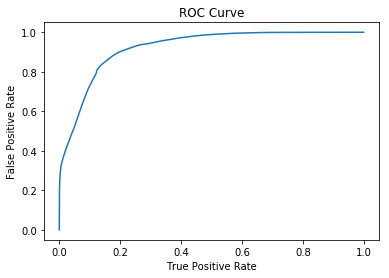

In [20]:
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

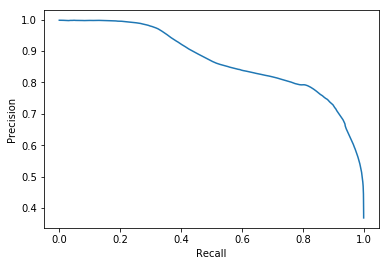

In [21]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'], pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

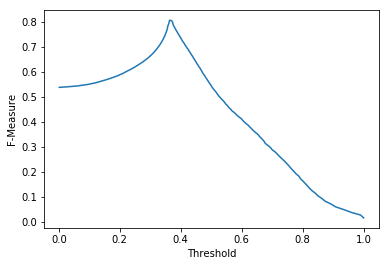

In [22]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'], f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()


In [ ]:
#TODO try Word2Vec features
#TODO try hash and td-idf
#TODO play with stopwords
#TODO implement language detection

NaiveBayes

In [25]:
nb = NaiveBayes(smoothing=1)
model_nb = nb.fit(trainingData)

In [26]:
predictionsnb = model_nb.transform(testData)
#predictionsnb.filter(predictionsnb['prediction'] == 0) \
#    .select("id_comentator","text","category","probability","label","prediction") \
#    .orderBy("probability", ascending=False) \
#    .show(n = 10, truncate = 30)

In [27]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictionsnb)

0.6755267906637568

In [28]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictionsnb, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.4731103530087829


Step 3


In [30]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsDataFrame = tokenizer.transform(countDistinctDF)

cv_tmp = CountVectorizer(inputCol="words", outputCol="tmp_vectors")
cv_tmp_model = cv_tmp.fit(wordsDataFrame)

top100 = list(cv_tmp_model.vocabulary[0:20])
more_then_3_charachters = [word for word in cv_tmp_model.vocabulary if len(word) <= 3]
contains_digits = [word for word in cv_tmp_model.vocabulary if any(char.isdigit() for char in word)]

stopwords = ['fuck', 'fake', "cool", "funny"] 

stopwords = stopwords + top100 + more_then_3_charachters + contains_digits
print(stopwords)
remover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords = stopwords)
wordsDataFrame = remover.transform(wordsDataFrame)

cv = CountVectorizer(inputCol="filtered", outputCol="features")
cvmodel = cv.fit(wordsDataFrame)
rescaledData = cvmodel.transform(wordsDataFrame)

#hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
#tf = hashingTF.transform(wordsDataFrame)
#idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)
#rescaledData = idf.transform(tf)
rescaledData.show()


In [31]:
predictions_all = model_nb.transform(rescaledData)


In [ ]:
predictions_all.head(3)


In [33]:
x = predictions_all.join(data, predictions_all.id_comentator == data.id_comentator, 'inner').drop(data.id_comentator)
x = x.dropDuplicates(["text", "id_comentator"])
x.head(5)

[Row(text=' Main Aisa Kyun Hoon one of best Bollywood video song. Please react to this.', words=['', 'main', 'aisa', 'kyun', 'hoon', 'one', 'of', 'best', 'bollywood', 'video', 'song.', 'please', 'react', 'to', 'this.'], filtered=['main', 'aisa', 'kyun', 'hoon', 'best', 'bollywood', 'video', 'song.', 'please', 'react', 'this.'], features=SparseVector(262144, {7: 1.0, 50: 1.0, 59: 1.0, 359: 1.0, 1182: 1.0, 1195: 1.0, 4634: 1.0, 40024: 1.0, 60746: 1.0, 73803: 1.0, 80407: 1.0}), rawPrediction=DenseVector([-112.6397, -112.3026]), probability=DenseVector([0.4165, 0.5835]), prediction=1.0, chan_owner='Alex Dauterive', id_comentator=' 1918156', text=' Main Aisa Kyun Hoon one of best Bollywood video song. Please react to this.'),
 Row(text=' We Should Probably Wrap This Up . No No No! Gotta Get An Outro.  Coyote Is Legendary', words=['', 'we', 'should', 'probably', 'wrap', 'this', 'up', '.', 'no', 'no', 'no!', 'gotta', 'get', 'an', 'outro.', '', 'coyote', 'is', 'legendary'], filtered=['should',

In [35]:
x.groupBy('words')\
    .count()\
    .sort('count', ascending=False)\
    .show(50)
#need to trim words on the first step

+--------------------+-----+
|               words|count|
+--------------------+-----+
|                [hi]| 4062|
|             [first]| 2390|
|          [so, cute]| 2360|
|[i, was, looking,...| 2015|
|               [wow]| 1960|
|               [lol]| 1956|
|[fabulous, doc!,,...| 1553|
|[scarlet|t, johan...| 1452|
|              [cool]| 1436|
|               [yes]| 1430|
|[theres, a, lot, ...| 1287|
|              [nice]| 1260|
|            [coyote]| 1252|
|[nope, i, still, ...| 1246|
|               [omg]| 1151|
|[be, careful, hum...| 1130|
|              [cute]| 1030|
|[our, winters, he...|  888|
|               [132]|  805|
|    [raptor, fossil]|  802|
|              [fake]|  768|
|                [no]|  764|
|[hes, very, happy...|  742|
|[sweet, story, gl...|  715|
|[dan, your, such,...|  714|
|[serca.ho, lejos,...|  693|
|[awww, very, cute...|  667|
|             [мурка]|  641|
|[lol, this, is, h...|  634|
|             [hello]|  630|
|[pretty, snake!,,...|  623|
|             

In [36]:
dog_owners = x.filter(x["prediction"] == 0)
cat_owners = x.filter(x["prediction"] == 1)


+--------------------+------------------+
|          chan_owner|   avg(prediction)|
+--------------------+------------------+
|   Best Bully Sticks|               0.5|
|      Allison Parker|               0.5|
|         Fan of 3ntv|              0.75|
|              Люда Т|0.5729166666666666|
|          nubianjuan|               1.0|
|              violet|               0.5|
|   АУДИОКНИГИ ОНЛАЙН| 0.580327868852459|
|            Monina48|0.6071428571428571|
|       Я аквариумист|            0.5625|
|       Multi console|               1.0|
|     Blade Brilliant|               0.6|
|          dkimmortal|               0.5|
|        Robert Gomez|               1.0|
|           Фея Алиса|               0.5|
|           VirusalTV|               0.5|
|       surferdude116|               0.5|
|  Sunset Marine Labs|0.6666666666666666|
|Drama 3/4 Product...|               0.5|
|Curialequarterhorses|               0.5|
|             TJ Ring|0.5454545454545454|
+--------------------+------------

In [37]:
dog_owners.groupBy('words')\
    .count()\
    .sort('count', ascending=False)\
    .show(50)


+--------------------+------------------+
|          chan_owner|   avg(prediction)|
+--------------------+------------------+
|   Best Bully Sticks|               0.5|
|      Allison Parker|               0.5|
|         Fan of 3ntv|              0.75|
|              Люда Т|0.5729166666666666|
|          nubianjuan|               1.0|
|              violet|               0.5|
|   АУДИОКНИГИ ОНЛАЙН| 0.580327868852459|
|            Monina48|0.6071428571428571|
|       Я аквариумист|            0.5625|
|       Multi console|               1.0|
|     Blade Brilliant|               0.6|
|          dkimmortal|               0.5|
|        Robert Gomez|               1.0|
|           Фея Алиса|               0.5|
|           VirusalTV|               0.5|
|       surferdude116|               0.5|
|  Sunset Marine Labs|0.6666666666666666|
|Drama 3/4 Product...|               0.5|
|Curialequarterhorses|               0.5|
|             TJ Ring|0.5454545454545454|
+--------------------+------------

In [39]:
cat_owners.groupBy('words')\
    .count()\
    .sort('count', ascending=False)\
    .show(50)


+--------------------+------------------+
|          chan_owner|   avg(prediction)|
+--------------------+------------------+
|   Best Bully Sticks|               0.5|
|      Allison Parker|               0.5|
|         Fan of 3ntv|              0.75|
|              Люда Т|0.5729166666666666|
|          nubianjuan|               1.0|
|              violet|               0.5|
|   АУДИОКНИГИ ОНЛАЙН| 0.580327868852459|
|            Monina48|0.6071428571428571|
|       Я аквариумист|            0.5625|
|       Multi console|               1.0|
|     Blade Brilliant|               0.6|
|          dkimmortal|               0.5|
|        Robert Gomez|               1.0|
|           Фея Алиса|               0.5|
|           VirusalTV|               0.5|
|       surferdude116|               0.5|
|  Sunset Marine Labs|0.6666666666666666|
|Drama 3/4 Product...|               0.5|
|Curialequarterhorses|               0.5|
|             TJ Ring|0.5454545454545454|
+--------------------+------------

In [49]:
mean_value = x.groupBy().avg("prediction")
mean_value.show()
#mean for whole dataset

+--------------------+------------------+
|          chan_owner|   avg(prediction)|
+--------------------+------------------+
|   Best Bully Sticks|               0.5|
|      Allison Parker|               0.5|
|         Fan of 3ntv|              0.75|
|              Люда Т|0.5729166666666666|
|          nubianjuan|               1.0|
|              violet|               0.5|
|   АУДИОКНИГИ ОНЛАЙН| 0.580327868852459|
|            Monina48|0.6071428571428571|
|       Я аквариумист|            0.5625|
|       Multi console|               1.0|
|     Blade Brilliant|               0.6|
|          dkimmortal|               0.5|
|        Robert Gomez|               1.0|
|           Фея Алиса|               0.5|
|           VirusalTV|               0.5|
|       surferdude116|               0.5|
|  Sunset Marine Labs|0.6666666666666666|
|Drama 3/4 Product...|               0.5|
|Curialequarterhorses|               0.5|
|             TJ Ring|0.5454545454545454|
+--------------------+------------

In [52]:
owner = x.groupby("chan_owner").avg("prediction")

owner.show()

+--------------------+------------------+
|          chan_owner|   avg(prediction)|
+--------------------+------------------+
|   Best Bully Sticks|               0.5|
|      Allison Parker|               0.5|
|         Fan of 3ntv|              0.75|
|              Люда Т|0.5729166666666666|
|          nubianjuan|               1.0|
|              violet|               0.5|
|   АУДИОКНИГИ ОНЛАЙН| 0.580327868852459|
|            Monina48|0.6071428571428571|
|       Я аквариумист|            0.5625|
|       Multi console|               1.0|
|     Blade Brilliant|               0.6|
|          dkimmortal|               0.5|
|        Robert Gomez|               1.0|
|           Фея Алиса|               0.5|
|           VirusalTV|               0.5|
|       surferdude116|               0.5|
|  Sunset Marine Labs|0.6666666666666666|
|Drama 3/4 Product...|               0.5|
|Curialequarterhorses|               0.5|
|             TJ Ring|0.5454545454545454|
+--------------------+------------

In [54]:
cat_ch = owner.filter(owner["avg(prediction)"] >= 0.5)
dog_ch = owner.filter(owner["avg(prediction)"] < 0.5)

+--------------------+------------------+
|          chan_owner|   avg(prediction)|
+--------------------+------------------+
|   Best Bully Sticks|               0.5|
|      Allison Parker|               0.5|
|         Fan of 3ntv|              0.75|
|              Люда Т|0.5729166666666666|
|          nubianjuan|               1.0|
|              violet|               0.5|
|   АУДИОКНИГИ ОНЛАЙН| 0.580327868852459|
|            Monina48|0.6071428571428571|
|       Я аквариумист|            0.5625|
|       Multi console|               1.0|
|     Blade Brilliant|               0.6|
|          dkimmortal|               0.5|
|        Robert Gomez|               1.0|
|           Фея Алиса|               0.5|
|           VirusalTV|               0.5|
|       surferdude116|               0.5|
|  Sunset Marine Labs|0.6666666666666666|
|Drama 3/4 Product...|               0.5|
|Curialequarterhorses|               0.5|
|             TJ Ring|0.5454545454545454|
+--------------------+------------

In [55]:
cat_ch.show()


+--------------------+------------------+
|          chan_owner|   avg(prediction)|
+--------------------+------------------+
|   Best Bully Sticks|               0.5|
|      Allison Parker|               0.5|
|         Fan of 3ntv|              0.75|
|              Люда Т|0.5729166666666666|
|          nubianjuan|               1.0|
|              violet|               0.5|
|   АУДИОКНИГИ ОНЛАЙН| 0.580327868852459|
|            Monina48|0.6071428571428571|
|       Я аквариумист|            0.5625|
|       Multi console|               1.0|
|     Blade Brilliant|               0.6|
|          dkimmortal|               0.5|
|        Robert Gomez|               1.0|
|           Фея Алиса|               0.5|
|           VirusalTV|               0.5|
|       surferdude116|               0.5|
|  Sunset Marine Labs|0.6666666666666666|
|Drama 3/4 Product...|               0.5|
|Curialequarterhorses|               0.5|
|             TJ Ring|0.5454545454545454|
+--------------------+------------

In [56]:
dog_ch.show()

+--------------------+--------------------+
|          chan_owner|     avg(prediction)|
+--------------------+--------------------+
|       Parrot Wizard| 0.16790123456790124|
|        TotallyDrawn| 0.25274725274725274|
|    Jonathan Seabolt| 0.07365145228215768|
|      Animals Attack| 0.09933774834437085|
|Monterey Bay Aqua...| 0.24249422632794457|
|          DUHorseman| 0.12244897959183673|
|Celebritytropical...|  0.2727272727272727|
|           SPINO REX| 0.37742504409171074|
|        Thefishguy12| 0.17391304347826086|
|          TimTools99|  0.1568627450980392|
|         SquidyMills|0.053763440860215055|
|       R2AK FILMBOSS| 0.26666666666666666|
|           Mr151josh|                0.25|
|     Jonette Crowley|                 0.0|
|                Rach|                 0.2|
|        Parelli Tube|                 0.2|
|      DanceMomsFan43| 0.16307053941908714|
|     Georgia Trapper|                 0.2|
|             Sandy G| 0.22288755821689954|
|  CathyFromPensacola| 0.3070175